# Projects

[![Binder](https://mybinder.org/badge_logo.svg)](https://mybinder.org/v2/git/https%3A%2F%2Fgitlab.in2p3.fr%2Fenergy4climate%2Fpublic%2Feducation%2Fmachine_learning_for_climate_and_energy/master?filepath=book%2Fnotebooks%2Fprojects.ipynb)

<div class="alert alert-block alert-warning">
    <b>Schedule</b>
    
- Ask your supervisors for the data if not already provided (it is not included in this repository).
- Quick presentation.
- Final project presentation.
    
</div>

<div class="alert alert-block alert-info">
    <b>One problematic, One dataset, One (or more) method(s)</b>
    
- Quality of the dataset is key.
- Results on a clean notebook.
- Explain which method(s) you used and why.
- If a method fails, explain why.

</div>

## Project: Weather station

- Suppose there are 5 weather stations that monitor the weather: Paris, Brest, London, Marseille and Berlin.
- The weather station in Paris breaks down
- Can we use the other stations to infer the weather in Paris?

<img alt="weather" src="images/map.png" width=400>

### Dataset

<img alt="weather" src="images/annual_temperature.png" width=400>

- Surface variables: skt, u10, v10, t2m, d2m, tcc, sp, tp, ssrd, blh
- Temporal resolution: hourly
- Spatial resolution: N/A

### First steps

- Look at the correlations between variables.
- What variable do I want to predict
- What time scale am interested in?
- Start with the easy predictions and move on to harder ones
- Are there events that are more predictable than others?

<Axes: xlabel='time'>

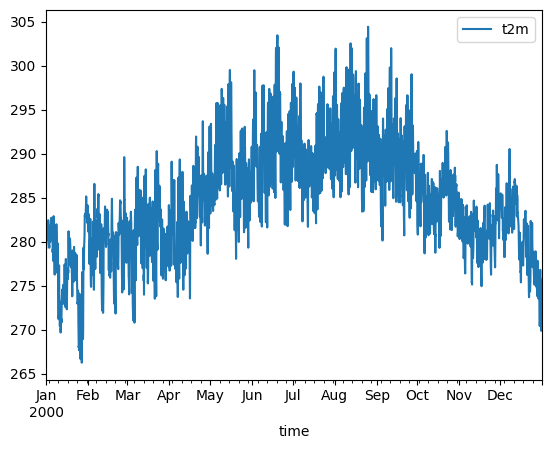

In [15]:
from pathlib import Path
import pandas as pd
import xarray as xr


import matplotlib.pyplot as plt

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

dir0 = Path('weather_data/paris/')
file_t2m = 't2m.nc'

ds = xr.open_dataset(Path(dir0, file_t2m))

# convert to pandas dataframe
df = ds.to_dataframe()

# remove latitude and longitude indices
df = df.droplevel([1,2])

df.loc['2000'].plot()

In [16]:
base_dir= Path("weather_data")

cities = ["paris", "brest", "marseille", "london", "berlin"]
var = "t2m"  # on commence par la température à 2m

In [17]:
def load_city_var(city: str, var: str = "t2m") -> pd.DataFrame:
    """
    Charge un fichier NetCDF pour une ville et une variable
    et renvoie un DataFrame pandas avec l'indice temporel
    et une seule colonne nommée var_city (ex: t2m_paris).
    """
    city_dir = base_dir / city
    file_path = city_dir / f"{var}.nc"
    print(f"Loading {file_path}")
    
    ds = xr.open_dataset(file_path)
    
    # Conversion en DataFrame
    df = ds.to_dataframe()
    
    # Si l'index est multi-index (time, lat, lon), on enlève lat/lon :
    # A adapter si ça plante : imprime df.index.names
    if isinstance(df.index, pd.MultiIndex):
        print("MultiIndex levels:", df.index.names)
        # on suppose l'ordre: time, latitude, longitude
        df = df.droplevel([1, 2])
    
    # garder uniquement la variable d'intérêt
    df = df[[var]].rename(columns={var: f"{var}_{city}"})
    
    return df


In [18]:
dfs = []

for city in cities:
    df_city = load_city_var(city, var=var)
    dfs.append(df_city)

# Fusion sur l'index temps (intersection des dates)
df_t2m = pd.concat(dfs, axis=1, join="inner").sort_index()


Loading weather_data\paris\t2m.nc
MultiIndex levels: ['time', 'latitude', 'longitude']
Loading weather_data\brest\t2m.nc
MultiIndex levels: ['time', 'latitude', 'longitude']
Loading weather_data\marseille\t2m.nc
MultiIndex levels: ['time', 'latitude', 'longitude']
Loading weather_data\london\t2m.nc
MultiIndex levels: ['time', 'latitude', 'longitude']
Loading weather_data\berlin\t2m.nc
MultiIndex levels: ['time', 'latitude', 'longitude']


,t2m_paris,t2m_brest,t2m_marseille,t2m_london,t2m_berlin
count,350640.000000,350640.000000,350640.000000,350640.000000,350640.000000
mean,284.363861,285.042114,288.001434,283.669647,282.741241
std,7.123538,4.206954,6.454230,5.922555,8.276498
min,256.771332,266.545654,266.325012,257.483673,251.373947
25%,279.320221,282.226852,283.138084,279.440552,276.518456
50%,284.179443,284.985764,287.711685,283.601471,282.662201
75%,289.236519,288.057495,293.046341,287.846313,288.725220
max,314.154785,304.947449,307.499115,308.787231,311.392822


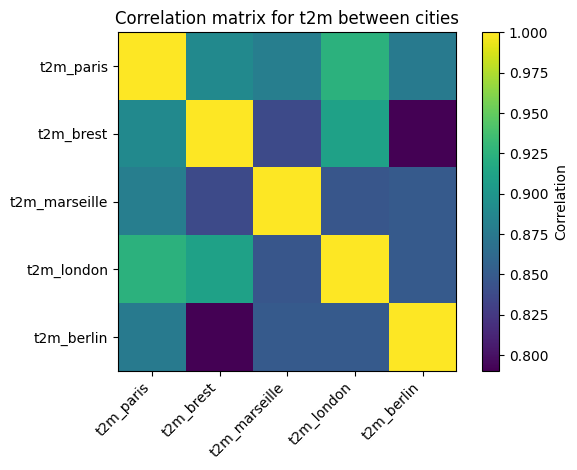

In [19]:
# Aperçu général
display(df_t2m.describe())

# Matrice de corrélation entre les 5 villes (t2m uniquement)
corr = df_t2m.corr()
corr

fig, ax = plt.subplots()
im = ax.imshow(corr.values, interpolation="nearest")
ax.set_xticks(range(len(corr.columns)))
ax.set_yticks(range(len(corr.index)))
ax.set_xticklabels(corr.columns, rotation=45, ha="right")
ax.set_yticklabels(corr.index)
plt.colorbar(im, ax=ax, label="Correlation")
plt.title("Correlation matrix for t2m between cities")
plt.tight_layout()
plt.show()



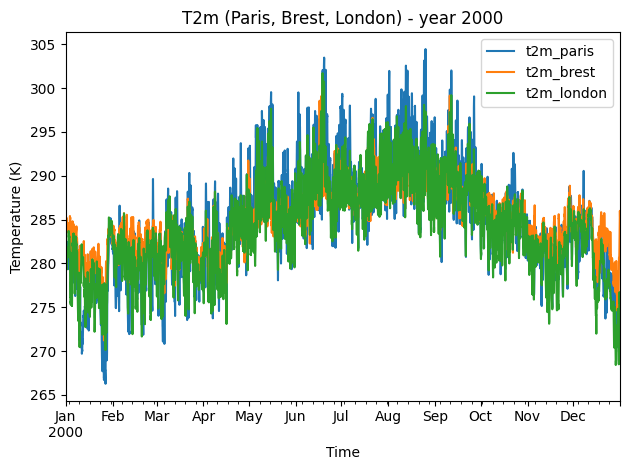

In [22]:
# On prend par exemple l'année 2000 pour ne pas avoir un plot énorme
df_2000 = df_t2m["2000-01-01":"2000-12-31"]

ax = df_2000[["t2m_paris", "t2m_brest", "t2m_london"]].plot()
ax.set_title("T2m (Paris, Brest, London) - year 2000")
ax.set_xlabel("Time")
ax.set_ylabel("Temperature (K)")
plt.tight_layout()
plt.show()


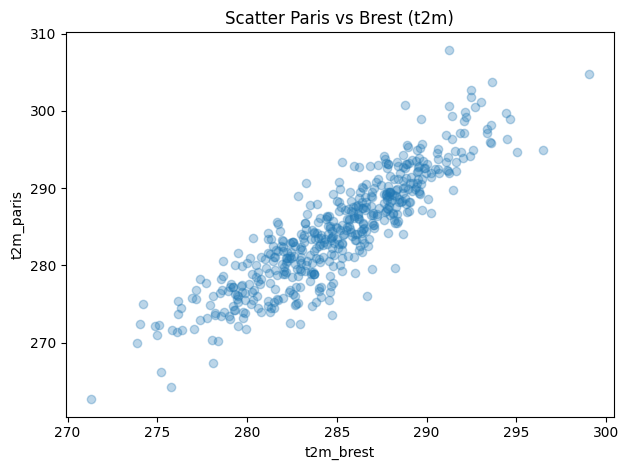

In [23]:
df_sample = df_t2m.sample(500)  # pour ne pas avoir 40 ans de points

plt.scatter(df_sample["t2m_brest"], df_sample["t2m_paris"], alpha=0.3)
plt.xlabel("t2m_brest")
plt.ylabel("t2m_paris")
plt.title("Scatter Paris vs Brest (t2m)")
plt.tight_layout()
plt.show()


In [24]:
df_daily = df_t2m.resample("D").mean().dropna()
df_daily.head()


,t2m_paris,t2m_brest,t2m_marseille,t2m_london,t2m_berlin
time,,,,,
1980-01-01,273.479401,278.610992,277.977997,271.535461,273.302643
1980-01-02,273.006409,277.607880,277.565491,271.127594,272.457001
1980-01-03,272.971161,282.995911,276.772858,275.419586,269.498505
1980-01-04,277.780121,283.077545,278.332184,280.108887,265.997406
1980-01-05,277.705780,282.259979,280.028534,277.335266,269.789520


In [25]:
target_col = "t2m_paris"
feature_cols = [c for c in df_daily.columns if c != target_col]

X = df_daily[feature_cols]
y = df_daily[target_col]

split_date = "2010-01-01"
X_train = X.loc[:split_date]
y_train = y.loc[:split_date]
X_test = X.loc[split_date:]
y_test = y.loc[split_date:]

X_train.shape, X_test.shape


((10959, 4), (3652, 4))

In [26]:
model = LinearRegression()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

rmse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("RMSE test:", rmse)
print("R² test :", r2)
print("Coefficients:")
for feat, coef in zip(feature_cols, model.coef_):
    print(f"  {feat}: {coef:.4f}")
print("Intercept:", model.intercept_)


RMSE test: 3.0489184856414795
R² test : 0.9280297756195068
Coefficients:
  t2m_brest: 0.3144
  t2m_marseille: 0.2116
  t2m_london: 0.4875
  t2m_berlin: 0.1842
Intercept: -56.624634


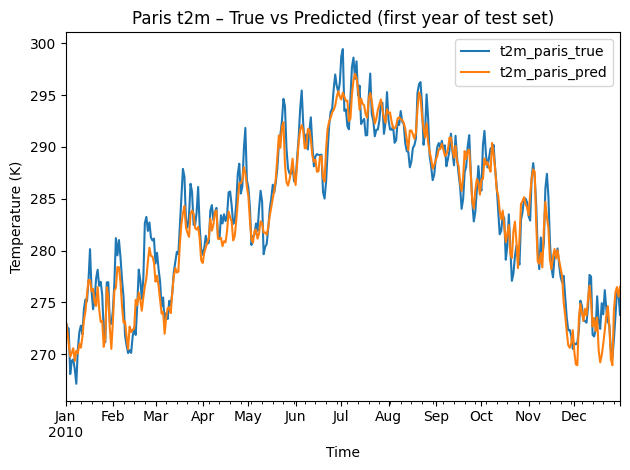

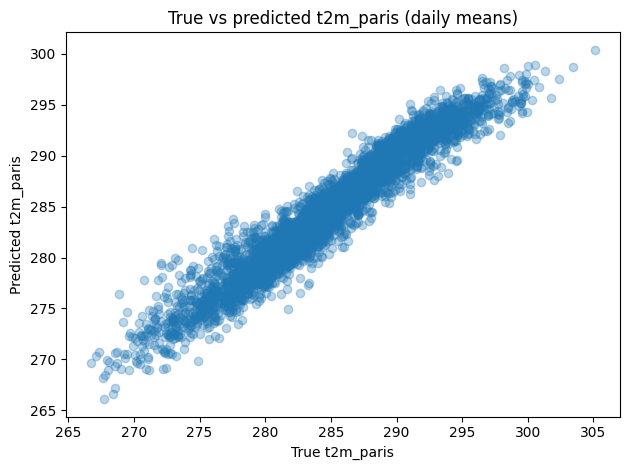

In [27]:
# Série temporelle : vérité vs prédiction
df_plot = pd.DataFrame(
    {
        "t2m_paris_true": y_test,
        "t2m_paris_pred": y_pred,
    },
    index=y_test.index,
)

ax = df_plot.iloc[:365].plot()  # par ex. première année du test
ax.set_title("Paris t2m – True vs Predicted (first year of test set)")
ax.set_xlabel("Time")
ax.set_ylabel("Temperature (K)")
plt.tight_layout()
plt.show()

# Nuage de points vrai vs prédit
plt.scatter(y_test, y_pred, alpha=0.3)
plt.xlabel("True t2m_paris")
plt.ylabel("Predicted t2m_paris")
plt.title("True vs predicted t2m_paris (daily means)")
plt.tight_layout()
plt.show()


***
## Credit

[//]: # "This notebook is part of [E4C Interdisciplinary Center - Education](https://gitlab.in2p3.fr/energy4climate/public/education)."
Contributors include Bruno Deremble and Alexis Tantet.
Several slides and images are taken from the very good [Scikit-learn course](https://inria.github.io/scikit-learn-mooc/).

<br>

<div style="display: flex; height: 70px">
    
<img alt="Logo LMD" src="images/logos/logo_lmd.jpg" style="display: inline-block"/>

<img alt="Logo IPSL" src="images/logos/logo_ipsl.png" style="display: inline-block"/>

<img alt="Logo E4C" src="images/logos/logo_e4c_final.png" style="display: inline-block"/>

<img alt="Logo EP" src="images/logos/logo_ep.png" style="display: inline-block"/>

<img alt="Logo SU" src="images/logos/logo_su.png" style="display: inline-block"/>

<img alt="Logo ENS" src="images/logos/logo_ens.jpg" style="display: inline-block"/>

<img alt="Logo CNRS" src="images/logos/logo_cnrs.png" style="display: inline-block"/>
    
</div>

<hr>

<div style="display: flex">
    <a rel="license" href="http://creativecommons.org/licenses/by-sa/4.0/"><img alt="Creative Commons License" style="border-width:0; margin-right: 10px" src="https://i.creativecommons.org/l/by-sa/4.0/88x31.png" /></a>
    <br>This work is licensed under a &nbsp; <a rel="license" href="http://creativecommons.org/licenses/by-sa/4.0/">Creative Commons Attribution-ShareAlike 4.0 International License</a>.
</div>